# WeatherPy

## Import Dependencies

In [7]:
# Import Dependencies
import json
import requests
from config import api_key
from pprint import pprint
import pandas as pd
from datetime import date
from datetime import timedelta
import requests
import urllib
from urllib.request import urlopen
import json
import matplotlib.pyplot as plt
import scipy.stats as st
from scipy.stats import linregress
import numpy as np
from citipy import citipy

## Generate Cities List

In [8]:
# Range of latitudes and longitudes
lat_range = (-90, 90)
lng_range = (-180, 180)

# List for holding lat_lngs and cities
lat_lngs = []
cities = []

# Create a set of random lat and lng combinations
lats = np.random.uniform(lat_range[0], lat_range[1], size=1500)
lngs = np.random.uniform(lng_range[0], lng_range[1], size=1500)
lat_lngs = zip(lats, lngs)

# Identify nearest city for each lat, lng combination
for lat_lng in lat_lngs:
    city = citipy.nearest_city(lat_lng[0], lat_lng[1]).city_name
    
    # If the city is unique, then add it to a our cities list
    if city not in cities:
        cities.append(city)

# Print the city count to confirm sufficient count
len(cities)

614

## Perform API Calls

In [9]:
# Extract the Weather Info for the 500 Cities using the Open Weather API

url = "https://api.openweathermap.org/data/2.5/weather"

# Create an empty Dataframe with the c
weather_pd = pd.DataFrame(columns=['City', 'Country', 'Cloud_Cover', 'Latitude', 'Longitude',
                               'Wind_Speed', 'Humidity','Temp', 'Temp_Min', 'Temp_Max', 'Hemi'])

# Create a separate list to store the errors
errors = []

# Set Index to 1
i = 1

# Loop through the cities list created in previous cell using Citypy to get Weather Data
for city in cities: 
    try:
        input_city = cities[i]
        query_url = url + "?q=" + input_city + "&appid=" + api_key

        try:
            weather_response = requests.get(query_url)
            weather_json = weather_response.json()  
            City = weather_json['name']
            Country = weather_json['sys']['country'] 
            Cloud_Cover = float(weather_json['clouds']['all'])
            Latitude = float(weather_json['coord']['lat'])
            Longitude = float(weather_json['coord']['lon'])
            Wind_Speed = float(weather_json['wind']['speed'])
            Humidity = float(weather_json['main']['humidity'])
            Temp = ((float(weather_json['main']['temp'])*1.8) - 459.67)
            Temp_Min = ((float(weather_json['main']['temp_min'])*1.8) - 459.67)
            Temp_Max = ((float(weather_json['main']['temp_max'])*1.8) - 459.67)
            if Latitude > 0:
                Hemi = 'North'
            elif Latitude < 0:
                Hemi = 'South'

            # Create a list of all the extracted columns from the JSON 
            current_record = [City, Country, Cloud_Cover, Latitude, Longitude, Wind_Speed, Humidity, Temp, Temp_Min, Temp_Max, Hemi]

            # Append the above list to the Weather Dataframe
            weather_pd.loc[len(weather_pd)] = current_record

        except KeyError:
            errors.append('Key Error')
        i = i+1
    except IndexError:
        errors.append('Index Out of Range')

In [10]:
# Display the Weather Data Frame
weather_pd

,City,Country,Cloud_Cover,Latitude,Longitude,Wind_Speed,Humidity,Temp,Temp_Min,Temp_Max,Hemi
0,Ushuaia,AR,75.0,-54.8000,-68.3000,14.92,70.0,40.658,40.658,40.658,South
1,Nebbi,UG,98.0,2.4783,31.0889,1.81,63.0,74.264,74.264,74.264,North
2,Sitka,US,75.0,57.0531,-135.3300,8.23,55.0,33.692,33.692,33.692,North
3,Alta Floresta,BR,97.0,-9.8756,-56.0861,1.50,95.0,77.126,77.126,77.126,South
4,Ribeira Grande,PT,75.0,38.5167,-28.7000,4.63,77.0,61.196,61.196,61.196,North
...,...,...,...,...,...,...,...,...,...,...,...
560,Mnogovershinnyy,RU,95.0,53.9353,139.9242,1.90,97.0,-24.376,-24.376,-24.376,North
561,Longido,TZ,7.0,-2.7333,36.6833,5.18,81.0,65.768,65.768,65.768,South
562,Plettenberg Bay,ZA,62.0,-34.0527,23.3716,0.99,77.0,61.736,61.736,61.736,South
563,Hope,US,100.0,33.6671,-93.5916,6.13,45.0,28.454,28.454,28.454,North


In [11]:
# Describe the Weather Data Frame Stats
weather_pd.describe()

,Cloud_Cover,Latitude,Longitude,Wind_Speed,Humidity,Temp,Temp_Min,Temp_Max
count,565.000000,565.000000,565.000000,565.00000,565.000000,565.000000,565.000000,565.000000
mean,60.000000,19.266775,21.144880,3.78154,73.711504,51.293451,50.492563,52.048113
std,39.827331,33.260926,88.731863,2.83203,20.262549,31.870893,31.998060,31.764087
min,0.000000,-54.800000,-175.200000,0.00000,15.000000,-56.614000,-56.614000,-56.614000
25%,18.000000,-7.470600,-56.154900,1.74000,63.000000,30.308000,30.236000,32.630000
50%,75.000000,22.566700,23.371600,3.11000,78.000000,61.916000,61.862000,63.104000
75%,100.000000,46.816800,100.202000,5.12000,89.000000,76.028000,75.704000,76.496000
max,100.000000,78.218600,179.316700,17.05000,100.000000,101.174000,101.174000,101.174000


## Inspect the data and remove the cities where the humidity > 100%.

In [12]:
weather_pd = weather_pd.loc[(weather_pd["Humidity"] <= 100)]
weather_pd.head()

,City,Country,Cloud_Cover,Latitude,Longitude,Wind_Speed,Humidity,Temp,Temp_Min,Temp_Max,Hemi
0,Ushuaia,AR,75.0,-54.8000,-68.3000,14.92,70.0,40.658,40.658,40.658,South
1,Nebbi,UG,98.0,2.4783,31.0889,1.81,63.0,74.264,74.264,74.264,North
2,Sitka,US,75.0,57.0531,-135.3300,8.23,55.0,33.692,33.692,33.692,North
3,Alta Floresta,BR,97.0,-9.8756,-56.0861,1.50,95.0,77.126,77.126,77.126,South
4,Ribeira Grande,PT,75.0,38.5167,-28.7000,4.63,77.0,61.196,61.196,61.196,North


## Write Dataframe to CSV File

In [13]:
output_data_file = "output_data/cities.csv"
weather_pd.to_csv(output_data_file, sep=',', index=False)

## Plotting the Data

### Latitude vs. Temperature Plot

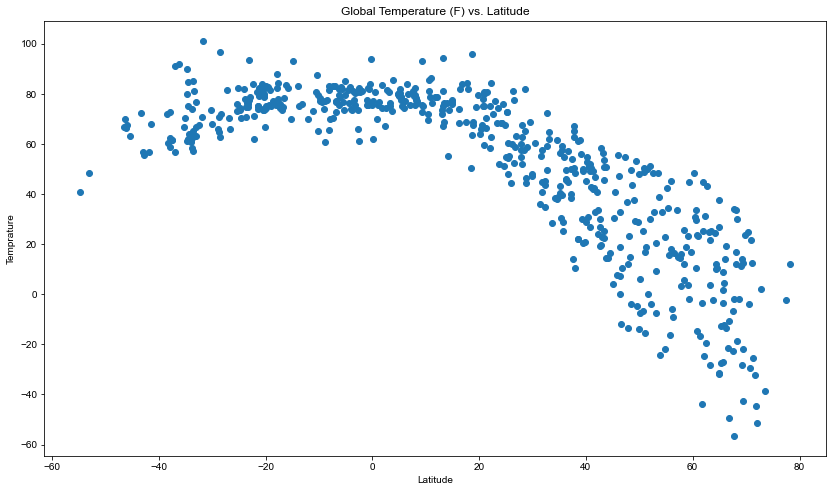

In [14]:
plt.rcParams["figure.figsize"] = (14,8)

x_values = weather_pd["Latitude"]
y_values = weather_pd["Temp"]

plt.scatter(x_values, y_values)


plt.title("Global Temperature (F) vs. Latitude")
plt.xlabel("Latitude")
plt.ylabel("Temprature")

plt.style.use("seaborn")
plt.show()

### Latitude vs. Humidity Plot

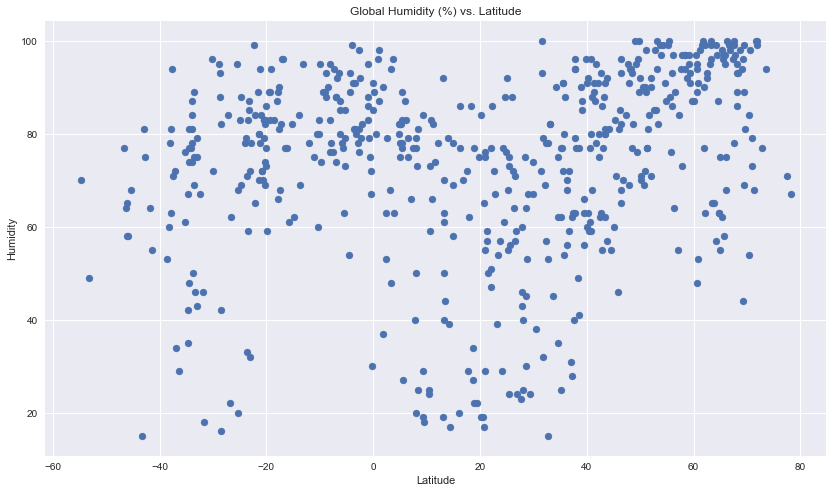

In [15]:
plt.rcParams["figure.figsize"] = (14,8)

x_values = weather_pd["Latitude"]
y_values = weather_pd["Humidity"]

plt.scatter(x_values, y_values)


plt.title("Global Humidity (%) vs. Latitude")
plt.xlabel("Latitude")
plt.ylabel("Humidity")

plt.style.use("seaborn")
plt.show()

### Latitude vs. Cloudiness Plot

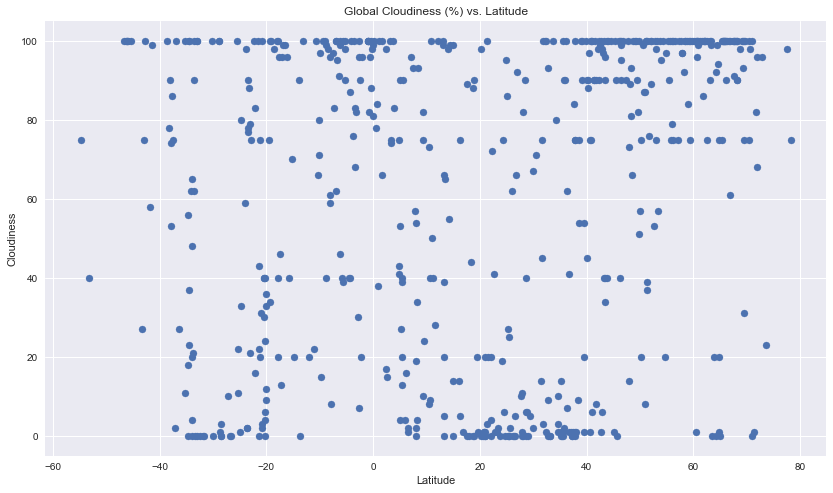

In [16]:
plt.rcParams["figure.figsize"] = (14,8)

x_values = weather_pd["Latitude"]
y_values = weather_pd["Cloud_Cover"]

plt.scatter(x_values, y_values)


plt.title("Global Cloudiness (%) vs. Latitude")
plt.xlabel("Latitude")
plt.ylabel("Cloudiness")

plt.style.use("seaborn")
plt.show()

### Latitude vs. Wind Speed Plot

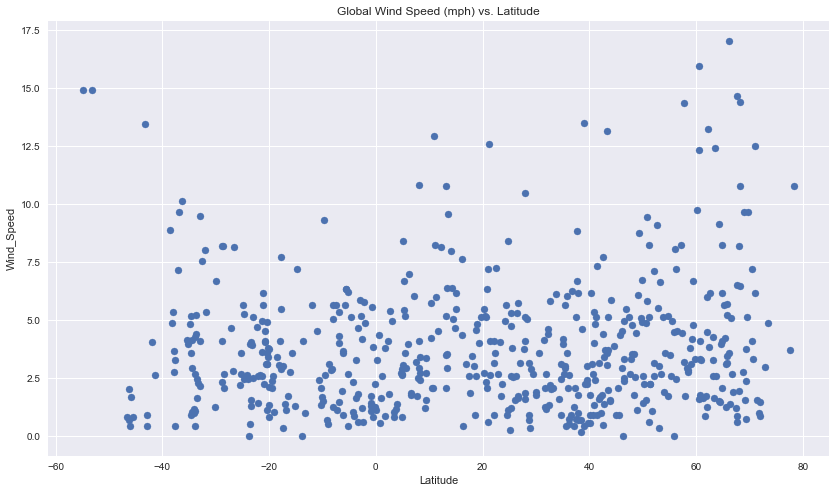

In [17]:
plt.rcParams["figure.figsize"] = (14,8)

x_values = weather_pd["Latitude"]
y_values = weather_pd["Wind_Speed"]

plt.scatter(x_values, y_values)


plt.title("Global Wind Speed (mph) vs. Latitude")
plt.xlabel("Latitude")
plt.ylabel("Wind_Speed")

plt.style.use("seaborn")
plt.show()

In [18]:
# Create A separate dataframe for Northern Hemisphere
North_Hemi = weather_pd.loc[(weather_pd["Hemi"] == "North")]
North_Hemi.head()

,City,Country,Cloud_Cover,Latitude,Longitude,Wind_Speed,Humidity,Temp,Temp_Min,Temp_Max,Hemi
1,Nebbi,UG,98.0,2.4783,31.0889,1.81,63.0,74.264,74.264,74.264,North
2,Sitka,US,75.0,57.0531,-135.3300,8.23,55.0,33.692,33.692,33.692,North
4,Ribeira Grande,PT,75.0,38.5167,-28.7000,4.63,77.0,61.196,61.196,61.196,North
6,Khatanga,RU,68.0,71.9667,102.5000,1.47,99.0,-51.304,-51.304,-51.304,North
7,Aklavik,CA,100.0,68.2191,-135.0107,6.49,89.0,-18.832,-18.832,-18.832,North


In [19]:
# Create A separate dataframe for Northern Hemisphere
South_Hemi = weather_pd.loc[(weather_pd["Hemi"] == "South")]
South_Hemi.head()

,City,Country,Cloud_Cover,Latitude,Longitude,Wind_Speed,Humidity,Temp,Temp_Min,Temp_Max,Hemi
0,Ushuaia,AR,75.0,-54.8000,-68.3000,14.92,70.0,40.658,40.658,40.658,South
3,Alta Floresta,BR,97.0,-9.8756,-56.0861,1.50,95.0,77.126,77.126,77.126,South
5,Kununurra,AU,40.0,-15.7667,128.7333,3.60,61.0,82.382,82.382,82.382,South
8,Carnarvon,AU,1.0,-24.8667,113.6333,5.66,83.0,73.472,73.472,73.472,South
10,Lebu,CL,86.0,-37.6167,-73.6500,3.29,94.0,61.358,61.358,61.358,South


## Linear Regression

####  Northern Hemisphere - Max Temp vs. Latitude Linear Regression

The correlation between Latitude and the Temprature is -0.84


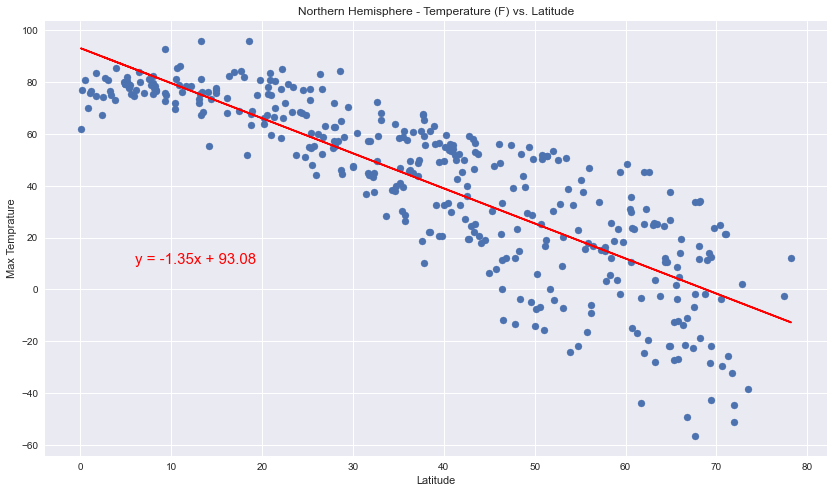

In [20]:
plt.rcParams["figure.figsize"] = (14,8)

x_values = North_Hemi["Latitude"]
y_values = North_Hemi["Temp_Max"]

correlation = st.pearsonr(x_values,y_values)
print(f"The correlation between Latitude and the Temprature is {round(correlation[0],2)}")

(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))


plt.scatter(x_values, y_values)

plt.plot(x_values,regress_values,"r-")

plt.annotate(line_eq,(6,10),fontsize=15,color="red")

plt.title("Northern Hemisphere - Temperature (F) vs. Latitude")
plt.xlabel("Latitude")
plt.ylabel("Max Temprature")

plt.style.use("seaborn")
plt.show()

####  Southern Hemisphere - Max Temp vs. Latitude Linear Regression

The correlation between Latitude and the Temprature is 0.45


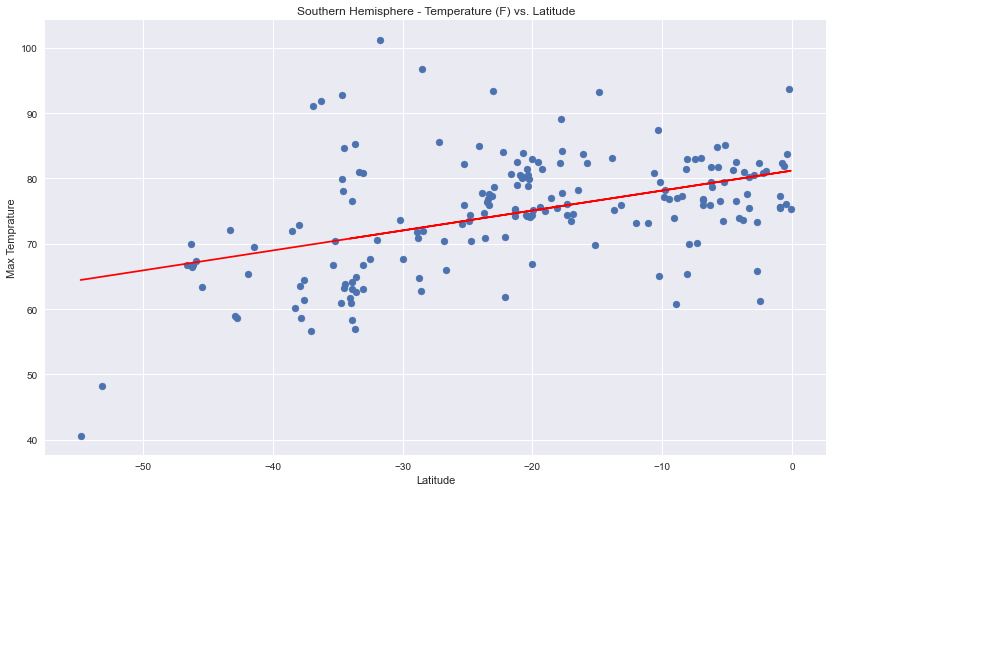

In [21]:
plt.rcParams["figure.figsize"] = (14,8)

x_values = South_Hemi["Latitude"]
y_values = South_Hemi["Temp_Max"]

correlation = st.pearsonr(x_values,y_values)
print(f"The correlation between Latitude and the Temprature is {round(correlation[0],2)}")

(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

plt.scatter(x_values, y_values)

plt.plot(x_values,regress_values,"r-")

plt.annotate(line_eq,(6,10),fontsize=15,color="red")

plt.title("Southern Hemisphere - Temperature (F) vs. Latitude")
plt.xlabel("Latitude")
plt.ylabel("Max Temprature")

plt.style.use("seaborn")
plt.show()

####  Northern Hemisphere - Humidity (%) vs. Latitude Linear Regression

The correlation between Latitude and the Humidity is 0.43


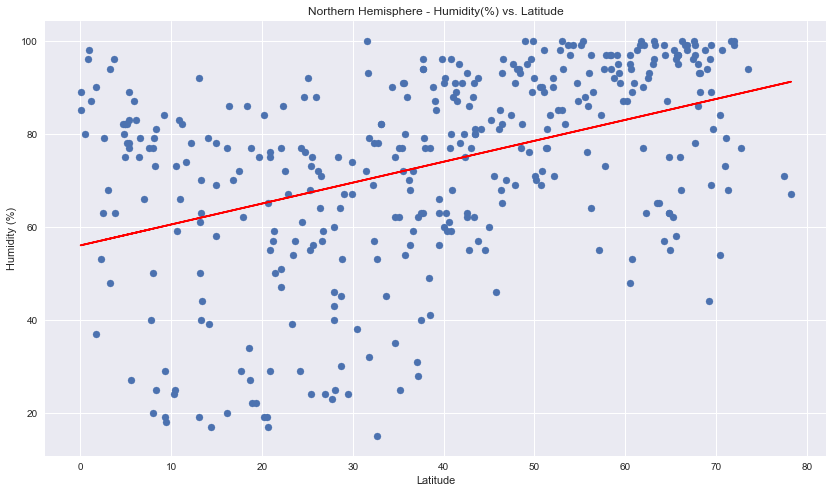

In [22]:
plt.rcParams["figure.figsize"] = (14,8)

x_values = North_Hemi["Latitude"]
y_values = North_Hemi["Humidity"]

correlation = st.pearsonr(x_values,y_values)
print(f"The correlation between Latitude and the Humidity is {round(correlation[0],2)}")

(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))


plt.scatter(x_values, y_values)

plt.plot(x_values,regress_values,"r-")

plt.annotate(line_eq,(6,10),fontsize=15,color="red")

plt.title("Northern Hemisphere - Humidity(%) vs. Latitude")
plt.xlabel("Latitude")
plt.ylabel("Humidity (%)")

plt.style.use("seaborn")
plt.show()

####  Southern Hemisphere - Humidity (%) vs. Latitude Linear Regression

The correlation between Latitude and the Humidity is 0.4


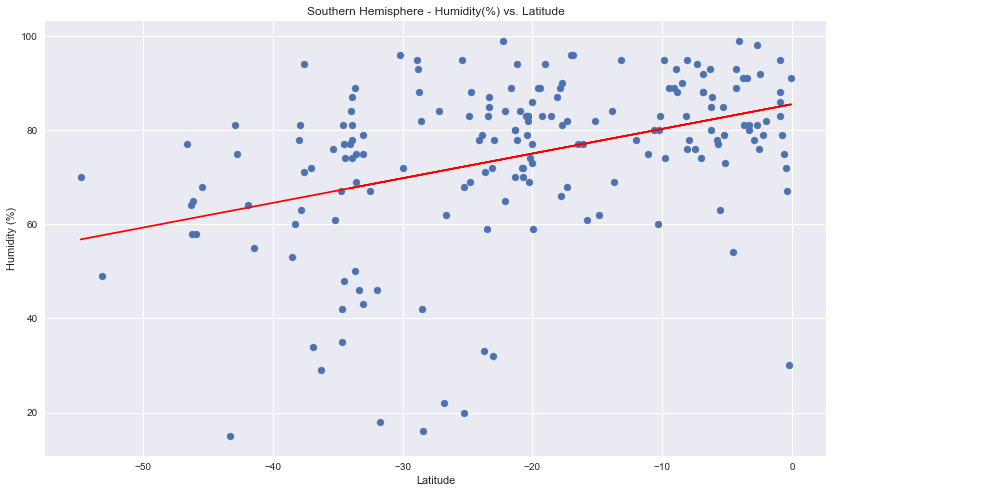

In [23]:
plt.rcParams["figure.figsize"] = (14,8)

x_values = South_Hemi["Latitude"]
y_values = South_Hemi["Humidity"]

correlation = st.pearsonr(x_values,y_values)
print(f"The correlation between Latitude and the Humidity is {round(correlation[0],2)}")

(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))


plt.scatter(x_values, y_values)

plt.plot(x_values,regress_values,"r-")

plt.annotate(line_eq,(6,10),fontsize=15,color="red")

plt.title("Southern Hemisphere - Humidity(%) vs. Latitude")
plt.xlabel("Latitude")
plt.ylabel("Humidity (%)")

plt.style.use("seaborn")
plt.show()

####  Northern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

The correlation between Latitude and the Cloudiness (%) is 0.4


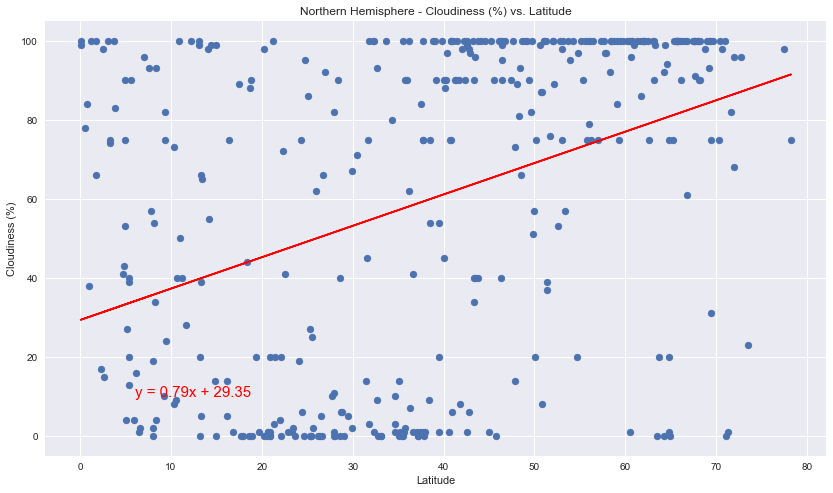

In [24]:
plt.rcParams["figure.figsize"] = (14,8)

x_values = North_Hemi["Latitude"]
y_values = North_Hemi["Cloud_Cover"]

correlation = st.pearsonr(x_values,y_values)
print(f"The correlation between Latitude and the Cloudiness (%) is {round(correlation[0],2)}")

(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))


plt.scatter(x_values, y_values)

plt.plot(x_values,regress_values,"r-")

plt.annotate(line_eq,(6,10),fontsize=15,color="red")

plt.title("Northern Hemisphere - Cloudiness (%) vs. Latitude")
plt.xlabel("Latitude")
plt.ylabel("Cloudiness (%)")

plt.style.use("seaborn")
plt.show()

####  Southern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

The correlation between Latitude and the Cloudiness (%) is 0.18


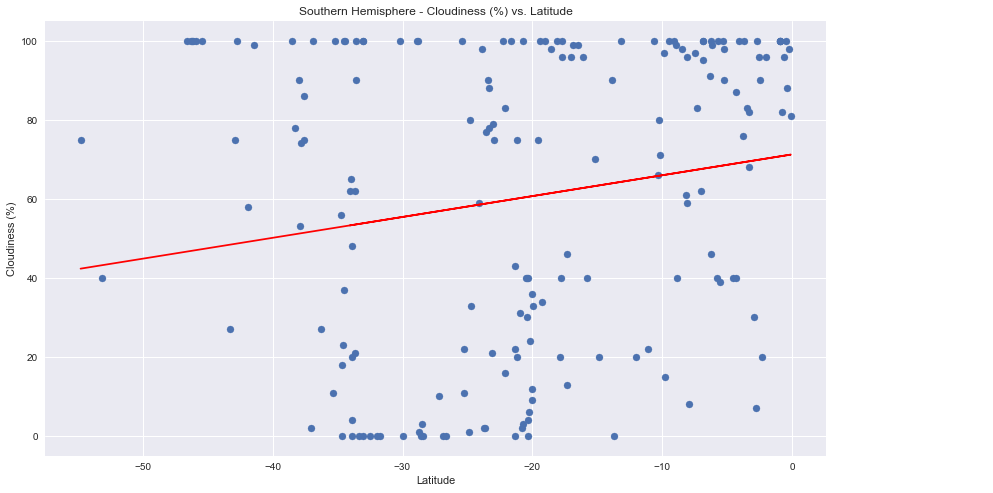

In [25]:
plt.rcParams["figure.figsize"] = (14,8)

x_values = South_Hemi["Latitude"]
y_values = South_Hemi["Cloud_Cover"]

correlation = st.pearsonr(x_values,y_values)
print(f"The correlation between Latitude and the Cloudiness (%) is {round(correlation[0],2)}")

(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))


plt.scatter(x_values, y_values)

plt.plot(x_values,regress_values,"r-")

plt.annotate(line_eq,(6,10),fontsize=15,color="red")

plt.title("Southern Hemisphere - Cloudiness (%) vs. Latitude")
plt.xlabel("Latitude")
plt.ylabel("Cloudiness (%)")

plt.style.use("seaborn")
plt.show()

####  Northern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression

The correlation between Latitude and the Wind_Speed (mph) is 0.13


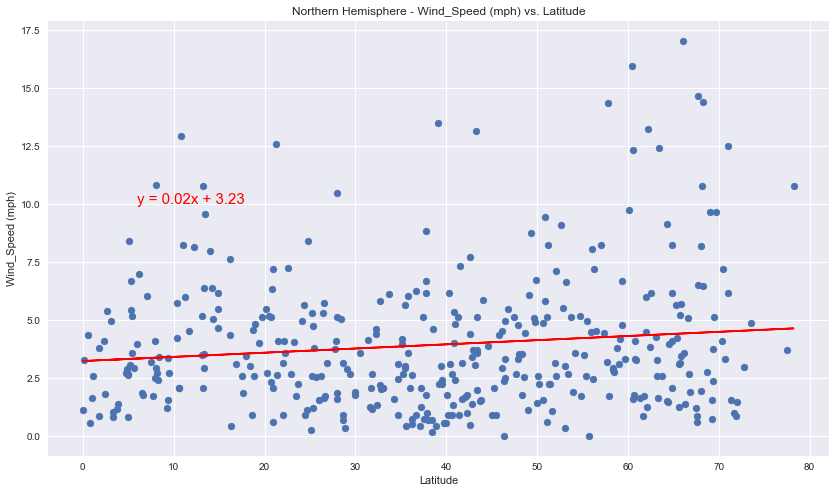

In [26]:
plt.rcParams["figure.figsize"] = (14,8)

x_values = North_Hemi["Latitude"]
y_values = North_Hemi["Wind_Speed"]

correlation = st.pearsonr(x_values,y_values)
print(f"The correlation between Latitude and the Wind_Speed (mph) is {round(correlation[0],2)}")

(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))


plt.scatter(x_values, y_values)

plt.plot(x_values,regress_values,"r-")

plt.annotate(line_eq,(6,10),fontsize=15,color="red")

plt.title("Northern Hemisphere - Wind_Speed (mph) vs. Latitude")
plt.xlabel("Latitude")
plt.ylabel("Wind_Speed (mph)")

plt.style.use("seaborn")
plt.show()

####  Southern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression

The correlation between Latitude and the Wind_Speed (mph) is -0.23


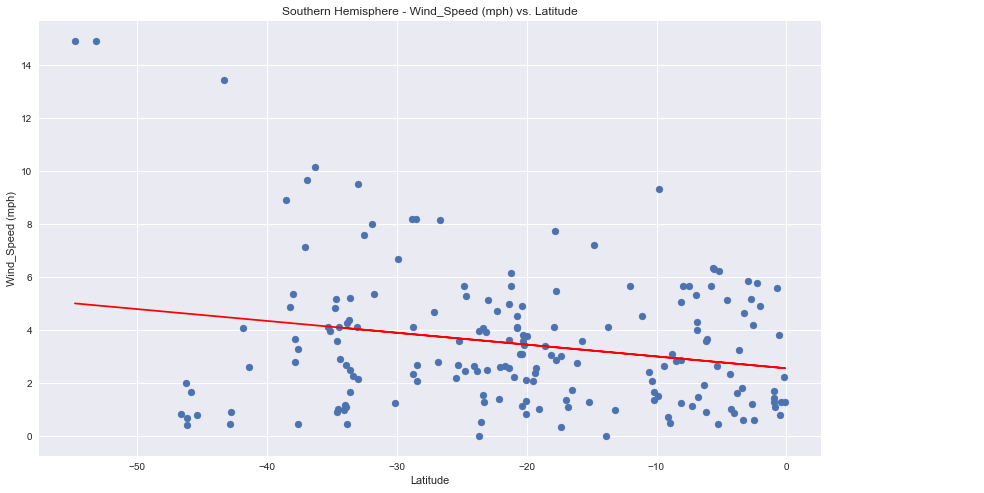

In [27]:
plt.rcParams["figure.figsize"] = (14,8)

x_values = South_Hemi["Latitude"]
y_values = South_Hemi["Wind_Speed"]

correlation = st.pearsonr(x_values,y_values)
print(f"The correlation between Latitude and the Wind_Speed (mph) is {round(correlation[0],2)}")

(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))


plt.scatter(x_values, y_values)

plt.plot(x_values,regress_values,"r-")

plt.annotate(line_eq,(6,10),fontsize=15,color="red")

plt.title("Southern Hemisphere - Wind_Speed (mph) vs. Latitude")
plt.xlabel("Latitude")
plt.ylabel("Wind_Speed (mph)")

plt.style.use("seaborn")
plt.show()